# Modeling Nationwide Pesticide Violations Using EPA ECHO & Spending Data

This notebook builds a **year-level machine learning model** to predict **nationwide pesticide violations per year** using:

- EPA ECHO *establishments* and *WPS* enforcement data  
- EPA spending data (`spending_data_master(in).csv`) aggregated to the national level  

The workflow:

1. Load and lightly clean the datasets  
2. Aggregate enforcement and violation metrics to **national totals by year**  
3. Aggregate **spending** to national totals by year  
4. Build a feature matrix combining enforcement, inspections, actions, penalties, and spending  
5. Engineer trend features (rolling averages, percent changes) without using `year` directly as a numeric predictor  
6. Fit a baseline **Random Forest regression model** to predict violations per year  
7. Evaluate performance and inspect feature importances  


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

plt.rcParams['figure.figsize'] = (8, 5)


## 1. Load Data

Update the file paths below if your CSV filenames differ. This notebook assumes:

- `wps-data (1).csv` — WPS data (state-level, multiple metrics by year)
- `establishments-data (1).csv` — establishment + inspections/violations/actions by year and state
- `spending_data_master(in).csv` — EPA spending data with `Year`, `State`, and `Total Obligation`


In [15]:
# Update these paths if your filenames or locations differ
wps_path = "wps-data (1).csv"
est_path = "establishments-data (1).csv"
spend_path = "obligation_by_state_year(in).csv"

wps = pd.read_csv(wps_path, low_memory=False)
est = pd.read_csv(est_path, low_memory=False)
spending = pd.read_csv(spend_path, low_memory=False)

print("WPS shape:", wps.shape)
print("Establishments shape:", est.shape)
print("Spending shape:", spending.shape)

wps.head()


WPS shape: (75, 566)
Establishments shape: (91, 61)
Spending shape: (542, 3)


,state,facilities-comm,facilities-ag,workers-comm,workers-ag,insp-state-2011,insp-tribe-2011,insp-epa-2011,viol_retaliation-state-2011,viol_retaliation-tribe-2011,...,enf_sentepa-epa-2021,enf_addl-state-2021,enf_addl-tribe-2021,enf_addl-epa-2021,enf_stopsale-state-2021,enf_stopsale-tribe-2021,enf_stopsale-epa-2021,enf_fines-state-2021,enf_fines-tribe-2021,enf_fines-epa-2021
0,National,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,NaN,NaN,NaN,NaN,98.0,NaN,NaN,0.0,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
2,Alaska,NaN,NaN,NaN,NaN,6.0,NaN,NaN,0.0,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
3,American Samoa,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
4,Arizona,NaN,NaN,NaN,NaN,101.0,NaN,NaN,1.0,NaN,...,NaN,25.0,NaN,NaN,0.0,NaN,NaN,10.0,NaN,NaN


## 2. Basic Cleaning & Aggregate Spending

We standardize column names by stripping whitespace, then aggregate **total EPA pesticide-related spending per year**.


In [16]:
# Normalize column names
wps.columns = wps.columns.str.strip()
est.columns = est.columns.str.strip()
spending.columns = spending.columns.str.strip()

# Rename spending columns to standard names
spending = spending.rename(columns={
    "Year": "year",
    "Total Obligation": "total_spending"
})

# # Aggregate spending to national totals per year
# spending_nat = (
#     spending.groupby("year")["total_spending"]
#     .sum()
#     .reset_index()
#     .sort_values("year")
# )

In [18]:
US_STATES = [
    "Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut",
    "Delaware","Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa",
    "Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan",
    "Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada","New Hampshire",
    "New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio",
    "Oklahoma","Oregon","Pennsylvania","Rhode Island","South Carolina","South Dakota",
    "Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia",
    "Wisconsin","Wyoming"
]

# rename the first column of est → "state"
est = est.rename(columns={est.columns[0]: "state"})

# if you also want this for wps:
wps = wps.rename(columns={wps.columns[0]: "state"})
est = est[est["state"].isin(US_STATES)].copy()
wps = wps[wps["state"].isin(US_STATES)].copy()

In [23]:
import pandas as pd

# --- Ensure first columns are named "state" ---
est = est.rename(columns={est.columns[0]: "state"})
wps = wps.rename(columns={wps.columns[0]: "state"})

# --- Infer years from the columns in est ---
years = sorted(
    int(col.split("-")[-1])
    for col in est.columns
    if col.startswith("violations-")
)

# ==========================================================
# 1. Aggregate EST dataset (your first 6 features)
# ==========================================================

rows_est = []

for year in years:
    row_cols_est = {
        "violations_total":     f"violations-{year}",
        "insp_epa_total":       f"inspections-epa-{year}",
        "insp_state_total":     f"inspections-state-{year}",
        "actions_epa_total":    f"actions-epa-{year}",
        "actions_state_total":  f"actions-state-{year}",
        "penalties_epa_total":  f"penalties-epa-{year}",
    }

    for state, df_state in est.groupby("state"):
        row = {"state": state, "year": year}

        for feature, colname in row_cols_est.items():
            if colname in df_state.columns:
                row[feature] = pd.to_numeric(df_state[colname], errors="coerce").sum(skipna=True)
            else:
                row[feature] = None

        rows_est.append(row)

est_agg = pd.DataFrame(rows_est)


# ==========================================================
# 2. Aggregate WPS dataset (your 3 WPS features)
# ==========================================================

rows_wps = []

for year in years:
    row_cols_wps = {
        "wps_insp_epa_total":   f"insp-epa-{year}",
        "wps_insp_state_total": f"insp-state-{year}",
        "wps_insp_tribe_total": f"insp-tribe-{year}",
    }

    for state, df_state in wps.groupby("state"):
        row = {"state": state, "year": year}

        for feature, colname in row_cols_wps.items():
            if colname in df_state.columns:
                row[feature] = pd.to_numeric(df_state[colname], errors="coerce").sum(skipna=True)
            else:
                row[feature] = None

        rows_wps.append(row)

wps_agg = pd.DataFrame(rows_wps)


# ==========================================================
# 3. Merge both aggregated datasets
# ==========================================================

features_df = (
    est_agg
    .merge(wps_agg, on=["state", "year"], how="outer")
    .sort_values(["state", "year"])
    .reset_index(drop=True)
)

features_df


,state,year,violations_total,insp_epa_total,insp_state_total,actions_epa_total,actions_state_total,penalties_epa_total,wps_insp_epa_total,wps_insp_state_total,wps_insp_tribe_total
0,Alabama,2011,5.0,0.0,23.0,3.0,8.0,1452.0,0.0,98.0,0.0
1,Alabama,2012,2.0,0.0,19.0,2.0,3.0,7220.0,0.0,107.0,0.0
2,Alabama,2013,1.0,0.0,24.0,1.0,1.0,1650.0,0.0,199.0,0.0
3,Alabama,2014,1.0,0.0,22.0,1.0,5.0,1650.0,0.0,239.0,0.0
4,Alabama,2015,2.0,0.0,29.0,1.0,9.0,19700.0,0.0,187.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
427,Wyoming,2015,1.0,19.0,0.0,1.0,0.0,4000.0,NaN,NaN,NaN
428,Wyoming,2016,2.0,9.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN
429,Wyoming,2017,1.0,29.0,0.0,1.0,0.0,2000.0,NaN,NaN,NaN
430,Wyoming,2018,2.0,13.0,0.0,2.0,0.0,4512.0,NaN,NaN,NaN


In [25]:
US_STATE_CODES = [
    "AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA",
    "KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ",
    "NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT",
    "VA","WA","WV","WI","WY"
]

US_STATES = [
    "Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut",
    "Delaware","Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa",
    "Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan",
    "Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada","New Hampshire",
    "New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio",
    "Oklahoma","Oregon","Pennsylvania","Rhode Island","South Carolina","South Dakota",
    "Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia",
    "Wisconsin","Wyoming"
]

CODE_TO_NAME = {c: n for c, n in zip(US_STATE_CODES, US_STATES)}

In [28]:
spending

,State,year,total_spending
0,AK,2008,477249
1,AK,2009,342080
2,AK,2010,303513
3,AK,2011,302213
4,AK,2012,311000
...,...,...,...
537,WV,2022,130000
538,WY,2008,102094
539,WY,2009,100000
540,WY,2010,0


In [29]:
spending = spending.rename(columns={"State": "state"})

# Convert codes to full names
spending["state"] = spending["state"].str.upper().map(CODE_TO_NAME)
final_df = (
    features_df
    .merge(spending, on=["state", "year"], how="left")
    .sort_values(["state", "year"])
    .reset_index(drop=True)
)

In [110]:
labor_intensity = pd.read_csv("labor_intensity_index.csv")
labor_intensity["state"] = labor_intensity["state_name"].str.title()
labor_intensity = labor_intensity.drop(columns=["state_name"])
df = final_df.merge(labor_intensity, on="state", how="left")


In [111]:
df

,state,year,violations_total,insp_epa_total,insp_state_total,actions_epa_total,actions_state_total,penalties_epa_total,wps_insp_epa_total,wps_insp_state_total,wps_insp_tribe_total,total_spending,Labor_Intensity_Index
0,Alabama,2011,5.0,0.0,23.0,3.0,8.0,1452.0,0.0,98.0,0.0,646300.0,0.331764
1,Alabama,2012,2.0,0.0,19.0,2.0,3.0,7220.0,0.0,107.0,0.0,49756.0,0.331764
2,Alabama,2013,1.0,0.0,24.0,1.0,1.0,1650.0,0.0,199.0,0.0,920000.0,0.331764
3,Alabama,2014,1.0,0.0,22.0,1.0,5.0,1650.0,0.0,239.0,0.0,913291.0,0.331764
4,Alabama,2015,2.0,0.0,29.0,1.0,9.0,19700.0,0.0,187.0,0.0,73000.0,0.331764
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,Wyoming,2015,1.0,19.0,0.0,1.0,0.0,4000.0,NaN,NaN,NaN,NaN,0.345543
428,Wyoming,2016,2.0,9.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,0.345543
429,Wyoming,2017,1.0,29.0,0.0,1.0,0.0,2000.0,NaN,NaN,NaN,NaN,0.345543
430,Wyoming,2018,2.0,13.0,0.0,2.0,0.0,4512.0,NaN,NaN,NaN,2800.0,0.345543


In [ ]:
df = shuffle(df, random_state=42).reset_index(drop=True)


In [163]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

# Shuffle entire dataset
# Drop state + year
# X = df.drop(columns=["state", "violations_total", 'actions_epa_total','penalties_epa_total'])
X = df[['year']]
y = df["violations_total"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [164]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    "max_depth": [2, 3, 4, 5, 6, 8, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8, 16],
    "max_features": [None, "sqrt", "log2"],
}

tree = DecisionTreeRegressor(random_state=0)

grid = GridSearchCV(
    tree,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)


Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Best parameters: {'max_depth': 2, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV score: -3.836755978789963e-05


In [165]:
rf = RandomForestRegressor(**grid.best_params_)

rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=2, max_features=None)

In [166]:
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", mse**0.5)
print("R²:", r2)


MSE: 193.7099278636841
RMSE: 13.917971399010852
R²: 0.13626076352629368


In [167]:
import numpy as np

importances = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print(importances)



  feature  importance
0    year         1.0


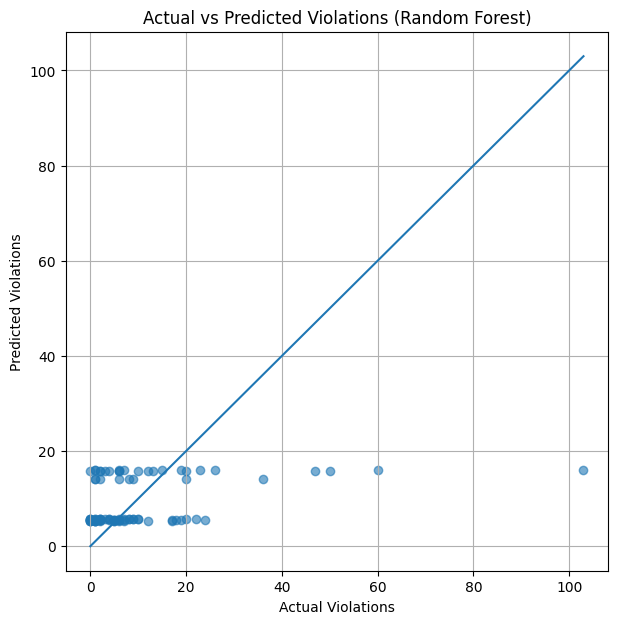

In [168]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy arrays to avoid index alignment issues
actual = np.array(y_test)
pred   = np.array(y_pred)

plt.figure(figsize=(7, 7))

# scatter points
plt.scatter(actual, pred, alpha=0.6)

# 45-degree reference line
min_val = min(actual.min(), pred.min())
max_val = max(actual.max(), pred.max())
plt.plot([min_val, max_val], [min_val, max_val])


plt.xlabel("Actual Violations")
plt.ylabel("Predicted Violations")
plt.title("Actual vs Predicted Violations (Random Forest)")
plt.grid(True)
plt.show()


## 4. Feature Engineering

We engineer additional features that encode intensity and trends without directly using `year` as a numeric feature:

- Ratios:
  - `viol_per_insp_epa` — violations per EPA inspection
  - `viol_per_insp_state` — violations per state inspection
- Rolling 3-year means for key enforcement metrics
- Year-over-year percent changes for key metrics and spending


In [10]:
features = features_df.copy()

# Helper for safe division
def safe_div(numer, denom):
    numer = np.asarray(numer, dtype=float)
    denom = np.asarray(denom, dtype=float)
    with np.errstate(divide="ignore", invalid="ignore"):
        result = np.where(denom > 0, numer / denom, np.nan)
    return result

# Ratios
if "insp_epa_total" in features.columns:
    features["viol_per_insp_epa"] = safe_div(features["violations_total"], features["insp_epa_total"])
if "insp_state_total" in features.columns:
    features["viol_per_insp_state"] = safe_div(features["violations_total"], features["insp_state_total"])

# Rolling means and percent changes for selected base columns
base_cols = [c for c in [
    "insp_epa_total",
    "insp_state_total",
    "actions_epa_total",
    "actions_state_total",
    "penalties_epa_total",
    "total_spending"
] if c in features.columns]

for col in base_cols:
    features[f"{col}_roll3"] = features[col].rolling(3, min_periods=1).mean()
    features[f"{col}_pctchg"] = features[col].pct_change()

# Clean up infinities / NaNs
features = features.replace([np.inf, -np.inf], np.nan)
features = features.fillna(0)

features


,year,violations_total,insp_epa_total,insp_state_total,actions_epa_total,actions_state_total,penalties_epa_total,wps_insp_epa_total,wps_insp_state_total,wps_insp_tribe_total,...,insp_state_total_roll3,insp_state_total_pctchg,actions_epa_total_roll3,actions_epa_total_pctchg,actions_state_total_roll3,actions_state_total_pctchg,penalties_epa_total_roll3,penalties_epa_total_pctchg,total_spending_roll3,total_spending_pctchg
0,2011,598.0,608.0,2188.0,520.0,552.0,7641568.0,12.0,3715.0,33.0,...,2188.000000,0.000000,520.000000,0.000000,552.000000,0.000000,7.641568e+06,0.000000,1.685318e+07,0.000000
1,2012,706.0,990.0,2192.0,602.0,398.0,17819834.0,37.0,3490.0,62.0,...,2190.000000,0.001828,561.000000,0.157692,475.000000,-0.278986,1.273070e+07,1.331960,1.697170e+07,0.014065
2,2013,508.0,606.0,2120.0,412.0,606.0,17627980.0,42.0,3604.0,59.0,...,2166.666667,-0.032847,511.333333,-0.315615,518.666667,0.522613,1.436313e+07,-0.010766,1.450282e+07,-0.440320
3,2014,496.0,626.0,2286.0,394.0,715.0,17627980.0,56.0,3390.0,172.0,...,2199.333333,0.078302,469.333333,-0.043689,573.000000,0.179868,1.769193e+07,0.000000,1.287964e+07,0.252856
4,2015,585.0,636.0,2348.0,486.0,556.0,7132396.0,24.0,3410.0,123.0,...,2251.333333,0.027122,430.666667,0.233503,625.666667,-0.222378,1.412945e+07,-0.595393,1.131256e+07,0.033828
5,2016,672.0,245.0,1142.0,610.0,211.0,3662818.0,11.0,3189.0,120.0,...,1925.333333,-0.513629,496.666667,0.255144,494.000000,-0.620504,9.474398e+06,-0.486453,1.232775e+07,0.017886
6,2017,980.0,272.0,1075.0,621.0,176.0,2348808.0,27.0,3271.0,108.0,...,1521.666667,-0.058669,572.333333,0.018033,314.333333,-0.165877,4.381341e+06,-0.358743,1.248255e+07,-0.012891
7,2018,771.0,274.0,959.0,697.0,135.0,9595106.0,10.0,3651.0,113.0,...,1058.666667,-0.107907,642.666667,0.122383,174.000000,-0.232955,5.202244e+06,3.085096,1.213308e+07,-0.088966
8,2019,749.0,265.0,873.0,681.0,136.0,3964558.0,12.0,3407.0,56.0,...,969.000000,-0.089677,666.333333,-0.022956,149.000000,0.007407,5.302824e+06,-0.586815,1.192710e+07,0.057498


## 5. Exploratory Time Series Plots

We quickly visualize nationwide:

- Violations per year  
- EPA & state inspections per year  
- Total spending per year  


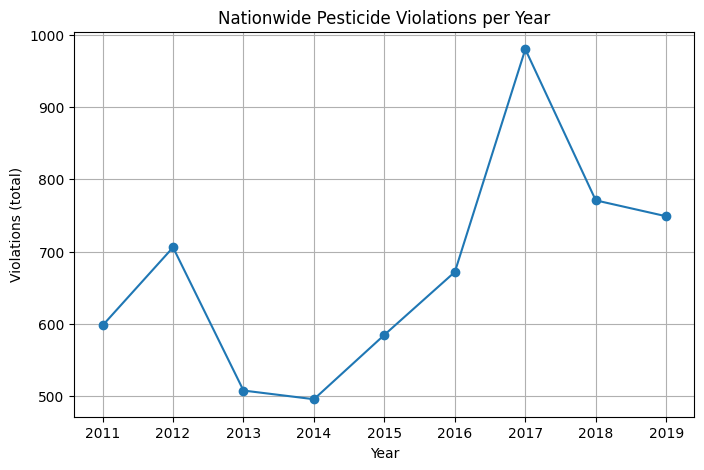

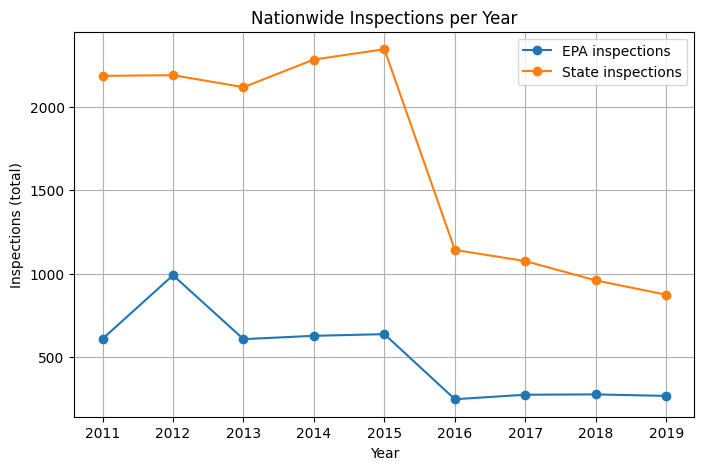

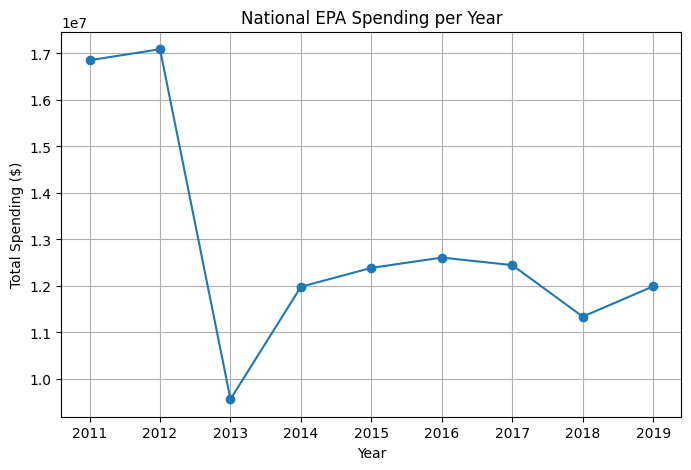

In [11]:
years = features["year"]

# Violations over time
plt.figure()
plt.plot(years, features["violations_total"], marker="o")
plt.title("Nationwide Pesticide Violations per Year")
plt.xlabel("Year")
plt.ylabel("Violations (total)")
plt.grid(True)
plt.show()

# Inspections (EPA & State)
if "insp_epa_total" in features.columns or "insp_state_total" in features.columns:
    plt.figure()
    if "insp_epa_total" in features.columns:
        plt.plot(years, features["insp_epa_total"], marker="o", label="EPA inspections")
    if "insp_state_total" in features.columns:
        plt.plot(years, features["insp_state_total"], marker="o", label="State inspections")
    plt.title("Nationwide Inspections per Year")
    plt.xlabel("Year")
    plt.ylabel("Inspections (total)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Total spending
if "total_spending" in features.columns and features["total_spending"].sum() > 0:
    plt.figure()
    plt.plot(years, features["total_spending"], marker="o")
    plt.title("National EPA Spending per Year")
    plt.xlabel("Year")
    plt.ylabel("Total Spending ($)")
    plt.grid(True)
    plt.show()


## 6. Baseline Random Forest Model

We fit a **Random Forest Regressor** to predict `violations_total` using enforcement, inspections, and spending features.  

We perform a simple time-based split: the earlier years form the training set, and the most recent years form the test set.


Train years: [2011, 2012, 2013, 2014, 2015, 2016]
Test years:  [2017, 2018, 2019]
R²: -3.369
MAE: 192.38


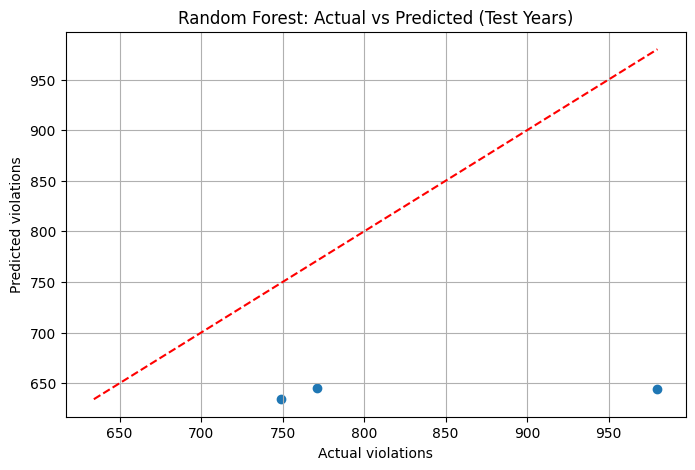

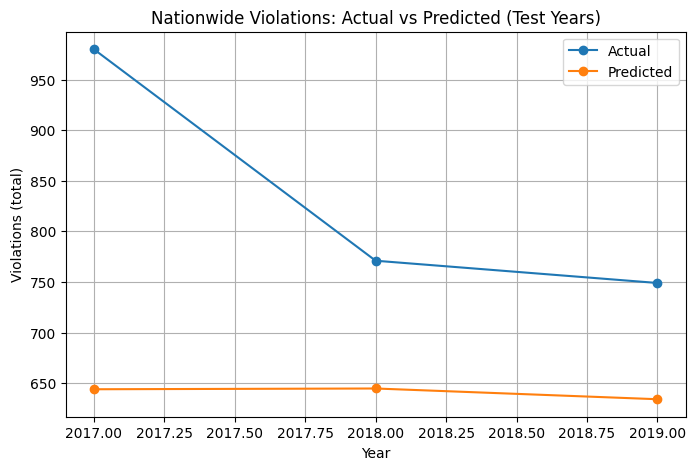

In [12]:
# Define target and features
target_col = "violations_total"
X = features.drop(columns=["year", target_col])
y = features[target_col]

# Time-based split (no shuffling)
n_years = len(features)
split_index = int(n_years * 0.7)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Train years: {features['year'].iloc[:split_index].tolist()}")
print(f"Test years:  {features['year'].iloc[split_index:].tolist()}")

# Fit Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("R²:", round(r2_score(y_test, y_pred), 3))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))

# Actual vs predicted scatter
plt.figure()
plt.scatter(y_test, y_pred)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.xlabel("Actual violations")
plt.ylabel("Predicted violations")
plt.title("Random Forest: Actual vs Predicted (Test Years)")
plt.grid(True)
plt.show()

# Time series: actual vs predicted
plt.figure()
test_years = features["year"].iloc[split_index:]
plt.plot(test_years, y_test.values, marker="o", label="Actual")
plt.plot(test_years, y_pred, marker="o", label="Predicted")
plt.title("Nationwide Violations: Actual vs Predicted (Test Years)")
plt.xlabel("Year")
plt.ylabel("Violations (total)")
plt.legend()
plt.grid(True)
plt.show()


## 7. Feature Importance

We inspect which features (inspections, actions, spending, trends) contribute most to the model's predictions.


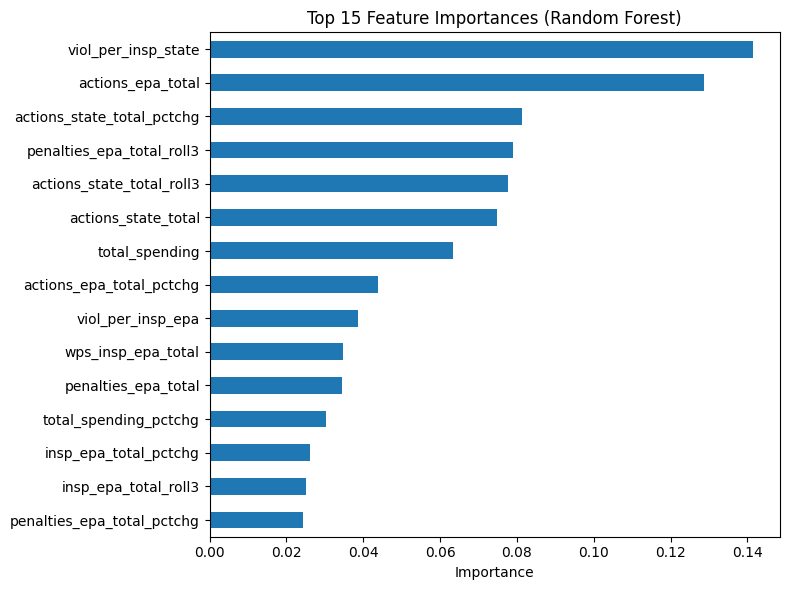

viol_per_insp_state           0.141437
actions_epa_total             0.128670
actions_state_total_pctchg    0.081233
penalties_epa_total_roll3     0.079009
actions_state_total_roll3     0.077714
actions_state_total           0.074823
total_spending                0.063469
actions_epa_total_pctchg      0.043856
viol_per_insp_epa             0.038736
wps_insp_epa_total            0.034821
penalties_epa_total           0.034531
total_spending_pctchg         0.030264
insp_epa_total_pctchg         0.026229
insp_epa_total_roll3          0.025164
penalties_epa_total_pctchg    0.024300
dtype: float64

In [13]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_imp = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 6))
top_imp[::-1].plot(kind="barh")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

top_imp


## 8. Interpretation & Next Steps

Questions to explore based on the model:

- Do **spending variables** (level, trend) appear among the top predictors?  
- Are **inspections** or **actions** more predictive of violations than **penalties**?  
- Does the model systematically under- or over-predict certain years (e.g., spikes)?  

Possible extensions:

1. **Lagged Features**  
   Add lagged versions of key variables (e.g., `total_spending` lagged by one year) to test whether spending affects **future** violations.

2. **Alternative Targets**  
   Model `violations per inspection` instead of raw violations to control for changes in inspection intensity.

3. **State-Level Modeling**  
   Build a panel dataset with `(state, year)` rows and use models that can capture variation across states (e.g., random forest with state dummies, or hierarchical models).
